# (0) Librairies

In [1]:
# (1) Importation des données
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

import openml
from openml import datasets as ml

# (2) Détecteur de 5
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

# (1) Importation des données

On sépare les images dans ```images``` et les labels dans ```labels```, on les mélange puis on crée un jeu de test et un d'entrainement:

In [2]:
dataset = ml.get_dataset(554)
data, y, cat_indicator, att_names = dataset.get_data(dataset_format = 'dataframe')

shuffle_index = np.random.permutation(70000)

Train = data.iloc[shuffle_index[:60000]] # <pandas.core.frame.DataFrame>
Test = data.iloc[shuffle_index[60000:70000]] # <pandas.core.frame.DataFrame>

Train.set_index(np.arange(0, 60000), inplace = True)
Test.set_index(np.arange(0, 10000), inplace = True)

Train_img = Train.drop('class', axis = 1, inplace = False)
Train_lab = Train['class']
Test_img = Test.drop('class', axis = 1, inplace = False)
Test_lab = Test['class']

/var/folders/l4/tj2026g138127nm7gbw5ljb00000gn/T/ipykernel_26435/3413094728.py:1: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = ml.get_dataset(554)


Utilisation basique des données:

1


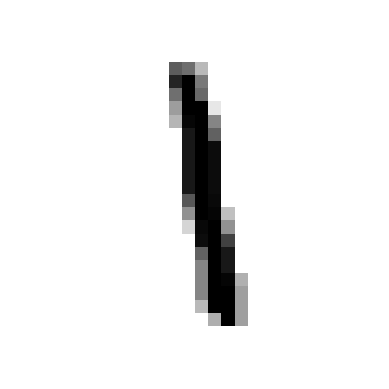

In [3]:
def affiche_data(i):
    print(data['class'][i])
    img = data.drop('class', axis = 1, inplace = False).iloc[i]
    img_tab = np.array(img).reshape((28, 28)).astype('float')

    fig = plt.figure(frameon=False)
    im2 = plt.imshow(img_tab, cmap = matplotlib.cm.binary, interpolation="nearest") 
    plt.axis("off")

    plt.show()
    
def affiche_Train(i):
    print(Train_lab.iloc[i])
    img = Train_img.iloc[i]
    
    img_tab = np.array(img).reshape((28, 28)).astype('float')
    fig = plt.figure(frameon=False)
    im2 = plt.imshow(img_tab, cmap = matplotlib.cm.binary, interpolation="nearest") 
    plt.axis("off")

    plt.show()

def affiche_Test(i):
    print(Test_lab.iloc[i])
    img = Test_img.iloc[i]
    
    img_tab = np.array(img).reshape((28, 28)).astype('float')
    fig = plt.figure(frameon=False)
    im2 = plt.imshow(img_tab, cmap = matplotlib.cm.binary, interpolation="nearest") 
    plt.axis("off")

    plt.show()
    
n = 283
affiche_Test(n)

# (2) Détecteur de 5

Nous allons commencer par détecter si un chiffre est un 5 ou non (classificateur binaire).

On commence par crée un vecteur d'étiquettes booléennes qui sont vraies si l'image est un 5:

In [ ]:
X = Train_img
y_5 = (Train_lab == '5')

On choisit ensuite un classificateur que l'on entraine avec les données:

In [ ]:
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X, y_5)

### a) Evaluation des performances

##### Première évaluation

Une première façon de faire est de tester le nombre de prédiction correcte:

In [ ]:
nbDonnees = 10000

shuffle_index = np.random.permutation(60000)
y_pred = sgd_clf.predict(X.iloc[shuffle_index[:nbDonnees]])
taux_pred = sum(y_pred == y_5[shuffle_index[:nbDonnees]]) / nbDonnees
taux_pred

Le problème est qu'il y a 90% de non-5. Le classificateur le plus bête (qui classe tout en non-5) aurait donc un score de 90%.

##### Matrice de confusion

Il s'agit d'une matrice dont chaque ligne représente une étiquette (exp: 5), chaque colonne une prédiction (exp: non-5), et les coefficients (i,j) sont donc le nombre de données avec l'étiquette i étant prédit avec l'étiquette j. <br>
On obtient les nombres de vrais/faux positifs/négatifs:

In [ ]:
confusion = confusion_matrix(y_5[shuffle_index[:nbDonnees]], y_pred)
TP = confusion[1][1]
FP = confusion[0][1]
TN = confusion[0][0]
FN = confusion[1][0]

confusion

##### Précision et rappel

Cette matrice devenant plus complexe lorsqu'on a beaucoup de classes, on utilise des outils plus simple.

On peut s'interresser aux valeurs réelles ou aux prédictions, positives ou négatives, classées correctement ou non. <br>
On définit ainsi 8 taux :
* ```TPR```: Taux de 5 détecté comme 5 (Rappel Positif) et ```?``` = 1 - ```TPR```
* ```FPR```: Taux de non 5 détecté comme 5 (False Positif Rate)
* ```TNR```: Taux de non-5 détecté comme non-5 (True Negatif Rate; spécificité) et ```RFN``` = 1 - ```RTN```
* ...

In [ ]:
# Rappel

# Valeurs positives classées...
TPR = TP / (TP + FN) # ... correctement (True Positif Rate; Rappel positif)
FNR = FN / (TP + FN) # ... incorrectement (Oubli positif)

# Valeurs négatives classées...
TNR = TN / (TN + FP) # ... correctement (True Negatif Rate; Spécificité; Rappel négatif)
FPR = FP / (TN + FP) # ... incorrectement (Oubli négatif)


# Précision

# Prédictions positives qui ont été classées...
precision = TP / (TP + FP) # ... correctement (Précision positive)
imprecision = FP / (TP + FP) # ... incorrectement (Imprécision négative)

# Prédictions négatives qui ont été classées...
prec_neg = TN / (TN + FN) # ... correctement (Précision négative)
imprec_neg = FN / (TN + FN) # ... incorrectement (Imprécision négative)

##### Moyenne harmonique

La moyenne harmonique de n taux est définie par: ```moy = n / sum(1 / taux[n])```.

In [ ]:
F1 = 2 / (1 / precision + 1 / TPR) # Score F1, moyenne de la précision et du rappel
F4 = 4 / sum([1 / taux for taux in [TPR, TNR, precision, prec_neg]])
F4_neg = 4 / sum([1 / taux for taux in [FNR, FPR, imprecision, imprec_neg]])

print('Precision: ', precision, '\nRappel: ', TPR, '\nF1: ', F1)

Le score F1 favorise les classificateurs ayant une précision et un rappel similaire. <br> Parfois, il faut accorder davantage d'importance à la précision, parfois au rappel (selon le problème à résoudre). C'est pourquoi on modifie le seuil à partir duquel une image est classée comme étant un 5:

In [ ]:
y_scores = sgd_clf.decision_function(X.iloc[shuffle_index[:nbDonnees]]) # <np.ndarray> shape nbDonnees

threshold = 2905 # Seuil: 9905 pour un rappel de 1
y_pred = y_scores > threshold

confusion = confusion_matrix(y_5[shuffle_index[:nbDonnees]], y_pred)

TP = confusion[1][1]
FP = confusion[0][1]
TN = confusion[0][0]
FN = confusion[1][0]

Precision = TP / (TP + FP)
Rappel = TP / (TP + FN)
F1 = 2 / (1/Precision + 1/Rappel)
print('Precision: ', Precision, '\nRappel: ', Rappel, '\nF1: ', F1)

On peut ainsi afficher des graphiques pour choisir le compromis à faire:
* Précision/Rappel (```precision```/```TPR```)
* ROC (```TPR```/```FPR```)
* Seuil (Courbe de rappel et de précision en fonction du seuil)
* ...

#### Affichage des graphiques

In [31]:
def affichage(yArg_true, yArg_scores, thresholds, xStr = 'threshold', yLst = ['precision', 'TPR', 'prec_neg', 'TNR']):
    """Affiche les courbes définies dans yLst en fonction de xStr

    Args:
        yArg_true (array-like): shape n, liste des labels réels
        yArg_scores (array-like): shape n, liste des scores des labels prédits
        thresholds (array-like): shape n, liste des seuils
        xStr (str): abscisse du graphique
        yLst (lst of str): ordonnées du graphique
    """
    
    P = sum(yArg_true) # Nombre de positifs
    N = len(yArg_true) - P # Nombre de négatifs
    T = len(thresholds)
    TP, FP , TN, FN = np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T)
    
    # Récupération des vrais/faux positifs/négatifs
    for i, threshold in enumerate(thresholds):
        y_pred = yArg_scores > threshold
        confusion = confusion_matrix(yArg_true, y_pred)

        TP[i] = confusion[1][1]
        FP[i] = confusion[0][1]
        
        TN[i] = confusion[0][0]
        FN[i] = confusion[1][0]
        
    # Définition de l'abscisse (u[0]) et ordonnées (u[i], i > 0)
    u = []
    
    for uStr in [xStr] + yLst:
        match uStr:
            case 'threshold': u += [thresholds]
            
            case 'TPR': u += [TP / (TP + FN)]
            case 'FNR': u += [FN / (TP + FN) ]

            case 'TNR': u += [TN / (TN + FP) ]
            case 'FPR': u += [FP / (TN + FP) ]

            case 'precision': u += [TP / (TP + FP)]
            case 'imprecision': u += [FP / (TP + FP)]

            case 'prec_neg': u += [TN / (TN + FN) ]
            case 'imprec_neg': u += [FN / (TN + FN) ]
    
    # Affichage
    for i, y in enumerate(u[1:]):
        plt.plot(u[0], y, label=yLst[i]) 
        
    plt.xlabel(xStr)
    plt.legend(loc="lower left")
    # plt.ylim([0, 1])

##### Courbe rappel/précision

In [ ]:
abscisse = 'TPR'
ordonnees = ['precision']

affichage(y_5[shuffle_index[:nbDonnees]], y_scores, range(-5000, 5000, 100), abscisse, ordonnees)
plt.show()

##### Courbe ROC

In [ ]:
abscisse = 'FPR'
ordonnees = ['TPR']

affichage(y_5[shuffle_index[:nbDonnees]], y_scores, range(-5000, 5000, 100), abscisse, ordonnees)
plt.show()

##### Courbes seuil

In [ ]:
abscisse = 'threshold'
ordonnees = ['precision', 'TPR', 'prec_neg', 'TNR']

affichage(y_5[shuffle_index[:nbDonnees]], y_scores, range(-5000, 5000, 100), abscisse, ordonnees)
plt.show()

#### Implémentation de la validation croisée

In [ ]:
skfolds = StratifiedKFold(n_splits=2, random_state = 42, shuffle = True)
model = sgd_clf
i = 0

for train_index, test_index in skfolds.split(Train_img, Train_lab): 
    print('\n', i)
    clone_clf = clone(model)
    
    print(' train')
    X_train = Train_img.iloc[train_index]
    y_train = Train_lab.iloc[train_index]

    print(' test')
    X_test = Train_img.iloc[test_index] 
    y_test = Train_lab.iloc[test_index]
    
    print(' fit')
    clone_clf.fit(X_train, y_train)
    
    print('predict')
    y_pred = clone_clf.predict(X_test)
    n_correct = sum(y_pred == y_test)
    
    print(n_correct / len(y_pred))
    i += 1

### b) Recherche et évaluation d'autres modèles


In [38]:
X = Train_img
Y = Train_lab
y_5 = (Train_lab == '5')


#### SGD

In [11]:
sgd_clf = SGDClassifier(random_state=42) 
y_scores_sgd = cross_val_predict(sgd_clf, X, y_5, cv=3, method="decision_function")

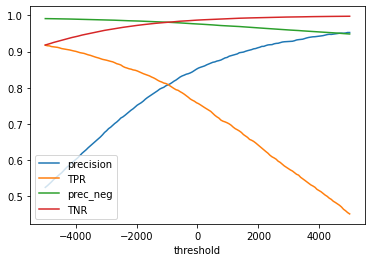

In [32]:
affichage(y_5, y_scores_sgd, np.linspace(-5000, 5000, 150))
plt.show()

#### Forêt aléatoire

In [20]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X, y_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]

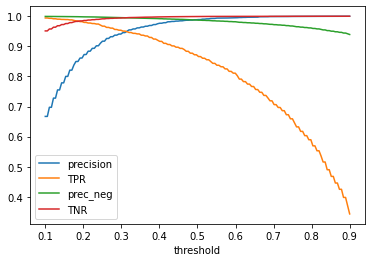

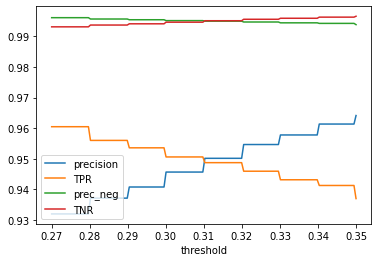

In [37]:
affichage(y_5, y_scores_forest, np.linspace(0.1, 0.9, 150))
plt.show()
affichage(y_5, y_scores_forest, np.linspace(0.27, 0.35, 150))
plt.show()

# (3) Classification multi-classe

Deux stratégies:
* OneVsAll: On entraine un classificateur comme ci-dessus par classe.
* OneVsOne: On entraine n(n-1)/2 classificateurs avec un jeu de données restreint à deux classes.

En général, on utilise le OneVsAll. Le OneVsOne est utile lorsqu'un algorithme préfère de petits jeux de données (comme le SVM).

```SGDClassifier``` utilise la stratégie OneVsAll par défaut lorsqu'on lui donne un jeu de données multi-classe:

In [39]:
sgd_clf = SGDClassifier(random_state=42) 
y_scores_sgd = cross_val_predict(sgd_clf, X, Y, cv=3, method="decision_function")

In [ ]:
def affichage(yArg_true, yArg_scores, thresholds, xStr = 'threshold', yLst = ['precision', 'TPR', 'prec_neg', 'TNR']):
    """Affiche les courbes définies dans yLst en fonction de xStr

    Args:
        yArg_true (array-like): shape n, liste des labels réels
        yArg_scores (array-like): shape n, liste des scores des labels prédits
        thresholds (array-like): shape n, liste des seuils
        xStr (str): abscisse du graphique
        yLst (lst of str): ordonnées du graphique
    """
    
    P = sum(yArg_true) # Nombre de positifs
    N = len(yArg_true) - P # Nombre de négatifs
    T = len(thresholds) # Nombre total de données
    nbClasses = len(np.unique(yArg_true)) # Nombre de classes
    
    # Récupération des vrais/faux positifs/négatifs
    for j in range(nbClasses):
        TP, FP, TN, FN = np.zeros(nbClasses, T), np.zeros(nbClasses, T), np.zeros(nbClasses, T), np.zeros(nbClasses, T)
        for i, threshold in enumerate(thresholds):
            y_pred = yArg_scores[:, j] > threshold
            confusion = confusion_matrix(yArg_true, y_pred)

            TP[j, i] = confusion[1][1]
            FP[j, i] = confusion[0][1]
            
            TN[j, i] = confusion[0][0]
            FN[j, i] = confusion[1][0]
        
    # Définition de l'abscisse (u[0]) et ordonnées (u[i], i > 0)
    u = []
    
    for uStr in [xStr] + yLst:
        match uStr:
            case 'threshold': u += [thresholds]
            
            case 'TPR': u += [TP / (TP + FN)]
            case 'FNR': u += [FN / (TP + FN) ]

            case 'TNR': u += [TN / (TN + FP) ]
            case 'FPR': u += [FP / (TN + FP) ]

            case 'precision': u += [TP / (TP + FP)]
            case 'imprecision': u += [FP / (TP + FP)]

            case 'prec_neg': u += [TN / (TN + FN) ]
            case 'imprec_neg': u += [FN / (TN + FN) ]
    
    # Affichage
    for i, y in enumerate(u[1:]):
        plt.plot(u[0], y, label=yLst[i]) 
        
    plt.xlabel(xStr)
    plt.legend(loc="lower left")
    # plt.ylim([0, 1])

In [49]:
y_scores_sgd[:, 0]


array([-29613.12605767,  27082.35774008, -54591.21673055, ...,
       -60262.4062281 , -57128.52065763,  38126.23875451])